# Linear System Identification 
(testing on unitary evolution performed by propagator)

In [1]:
using LinearAlgebra
using ControlSystems
using DifferentialEquations
using Plots


(process:14508): GLib-GIO-WARNING **: 12:23:02.717: Unexpectedly, UWP app `Microsoft.MSPaint_6.2203.1037.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.MSPaint_8wekyb3d8bbwe!Microsoft.MSPaint') supports 17 extensions but has no verbs


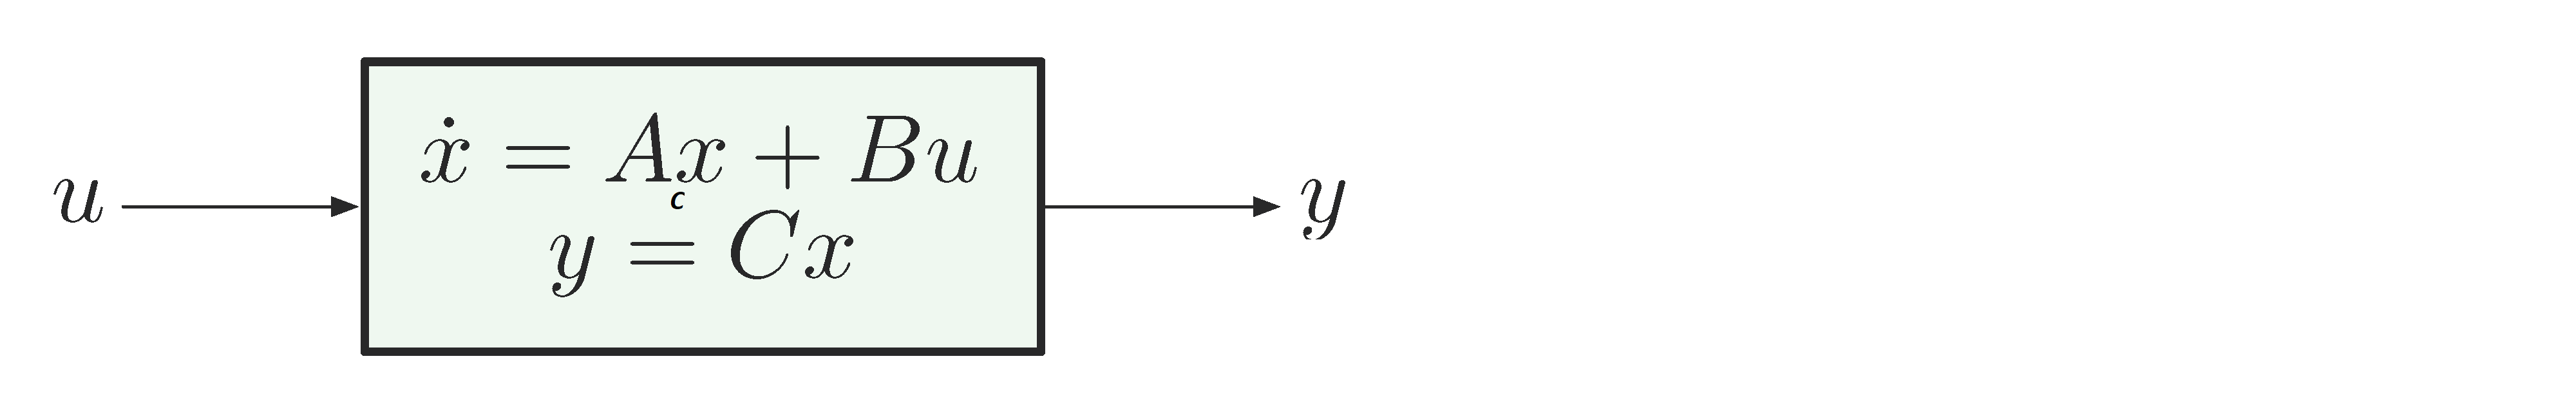

Consider LTI system with $n$-dimensional state vector $\mathbf{x}$, with  $m$-dimentional output vector $\mathbf{y}$ and no control ($u \equiv 0 $).

We have equation of motion and response:

\begin{align}
    \frac{d\mathbf{x}(t)} {dt} = A_c  \mathbf{x}(t) \label{Eq:SID:AEqMotion}
\end{align}

\begin{align}
    \mathbf{y}(t) = C \mathbf{x}(t) \label{Eq:SID:AOutput}
\end{align}


Given the initial conditions $\mathbf{x}(t_0) = \mathbf{x}(0)$ at some time $t=t_0=0$ and solving this equation of motion yields:
\begin{align}
    \mathbf{x}(t) = e^{A_c t}\mathbf{x}(0)  \notag
\end{align}

We use the equation of motion to introduce $A$ the field-free propagator:

\begin{align}\label{EqSIPropagatorsDefs}
    A = \exp(A_c \Delta t), 
    \\
     \operatorname{dim}[A] =  \operatorname{dim}[A_c] = n \times n \notag
\end{align}

the dynamics of the state vector reads as
\begin{align}
     \begin{cases}
        \mathbf{x}(0), & \\
        \mathbf{x}(\Delta t) &= A \mathbf{x}(0), \\
        \mathbf{x}(2\Delta t) &= A \mathbf{x}(\Delta t) = A^2 \mathbf{x}(0), \\
        &\vdots \notag\\
        \mathbf{x}(N \Delta t) &= A^N \mathbf{x}(0), \\
    \end{cases} \\
\end{align}

corresponding response $\mathbf{y}(t)$ is


\begin{align}
    \begin{cases}
        \mathbf{y}(0) &= C \mathbf{x}(0), \\
        \mathbf{y}(\Delta t) &=  CA\mathbf{x}(0),\\
        &\vdots \notag\\
        \mathbf{y}(N\Delta t) &= C A^N \mathbf{x}(0), \\
    \end{cases} \\
 \end{align}

Now consider the Hankel matrix $H$ of the outputs constructed in the following way:

$\begin{align} \label{EqHankMatrix}
    H = \left[
        \begin{array}{ccccc}
             \mathbf{y}(0)  &  \mathbf{y}(\Delta t)  & \dots &  \mathbf{y}(q\Delta t) \\
             \mathbf{y}(\Delta t)  &  \mathbf{y}(2\Delta t)  & \dots &  \mathbf{y}([q+1]\Delta t) \\
             \mathbf{y}(2\Delta t) &   \mathbf{y}(3\Delta t) & \dots &  \mathbf{y}([q+2]\Delta t) \\
             \vdots & \vdots &  & \vdots\\
              \mathbf{y}(q\Delta t) &  \mathbf{y}([q+1]\Delta t) & \dots &   \mathbf{y}(2q\Delta t) \\
        \end{array}
    \right] \notag 
    = \left[
        \begin{array}{ccccc}
             C\mathbf{x}(0)  &  CA\mathbf{x}(0)  & \dots &  C A^q \mathbf{x}(0) \\
             CA \mathbf{x}(0) &  C A^2 \mathbf{x}(0) & \dots &  C A^{q+1} \mathbf{x}(0)\\
             C A^2  \mathbf{x}(0) &   C A^3 \mathbf{x}(0)  & \dots &  C A^{q+2} \mathbf{x}(0)\\
             \vdots & \vdots &  & \vdots\\
              C A^q \mathbf{x}(0) &  C A^{q+1} \mathbf{x}(0) & \dots &   C A^{2q} \mathbf{x}(0) \\
        \end{array}
    \right]
\end{align}$

In [2]:
function hankel(y::AbstractArray)
    m, time_duration = size(y) # m - dimention of output vector y, time_duration - length of timeseries (number of time steps)
    q = Int(round(time_duration/2)) # q - is the size of Hankel matrix 
    H = zeros(eltype(y), q * m , q) 
    for r = 1:q, c = 1:q # r - rows, c -columns
        H[(r-1)*m+1:r*m, c] = y[:, r+c-1]
    end
    return H, m
end

hankel (generic function with 1 method)

It is obvious from the structure of the Hankel matrix $H$ that it can be represented as product of block matrices as follows:

\begin{align}
    H = \left[
        \begin{array}{ccccc}
             C   \\
             CA   \\
             CA^2  \\
             \vdots \\
             CA^q \\
        \end{array}
    \right]
    \left[
        \begin{array}{ccccc}
             I\mathbf{x}(0)  &  A\mathbf{x}(0)  & \dots &  A^q \mathbf{x}(0) \\
        \end{array}
    \right]
\end{align}

Lets consider Singular Value Decomposition of the Hankel matrix $H = \mathfrak{U} \Sigma \mathfrak{V^{\dagger}}$ to find the parts of product representation we are looking for:



\begin{align}
    U = \mathfrak{U} \sqrt{\Sigma} = \left[
        \begin{array}{ccccc}
             C   \\
             CA   \\
             CA^2  \\
             \vdots \\
             CA^q \\
        \end{array}
    \right] & &
V^{\dagger} = \sqrt{\Sigma} \mathfrak{V}^{\dagger} = 
     \begin{bmatrix}
    I \mathbf{x}(0)  & A \mathbf{x}(0) &  \dots & A^q \mathbf{x}(0)  
     \end{bmatrix} \\
\end{align}
$\operatorname{dim}[V^{\dagger} ] = n \times q \notag$

$C$ = the first $m$ rows of $U$

\begin{align}
    U_{\uparrow} = \left[
        \begin{array}{c}
            { C   }\\
            { CA  }\\
             \vdots \\
             {C A^{q-1}  }
        \end{array}
    \right]
\end{align}

\begin{align}
    U_{\downarrow} = \left[
        \begin{array}{c}
            { CA   }\\
            { CA^2  }\\
             \vdots \\
             {C A^{q}  }
        \end{array}
    \right] = U_{\uparrow} A
\end{align}


\begin{align}
     \operatorname{dim}[U_{\uparrow}] = \operatorname{dim}[U_{\downarrow}] = m[q-1] \times n \notag
\end{align}

Matrix $A$ of the system could be found just as a product of pseudo inverse of $U_{\uparrow}$ and $U_{\downarrow}$, and matrix $A_c$ as a matrix logarithm of $A$ divided by time step $\Delta t$:

\begin{align}
    A = U_{\uparrow}^{pinv}  U_{\downarrow} \\
    A_c = \frac{\log A}{\Delta t} \label{eq: Ac}
\end{align}


We can also find initial state of the system in a following way:

\begin{align} \label{EqHank1Matrix}
    H_0 = \left[
        \begin{array}{ccccc}
             \mathbf{y}(0\Delta t)   \\
             \mathbf{y}(1\Delta t)   \\
             \mathbf{y}(2\Delta t)  \\
             \vdots \\
              \mathbf{y}(q\Delta t)  \\
        \end{array}
    \right]
    = \left[
        \begin{array}{ccccc}
             C\mathbf{x}(0)   \\
             CA \mathbf{x}(0) \\
             CA^2  \mathbf{x}(0) \\
             \vdots \\
              C A^q \mathbf{x}(0) \\
        \end{array}
    \right]
    = U \mathbf{x}(0)
\end{align}




\begin{align}
\mathbf{x}(0) = U^{pinv} H_0 
\end{align}

### Main Linear System Identification function

In [3]:
using LinearAlgebra

function lsid(Y::AbstractArray, Δt, δ = 1e-6) 
    # y - output time series dim[y] = m x number_of_time_steps
    # δ - precission cutoff all the smaller values of Σ will be discarded 
    
    H, m = hankel(Y) # Hankel matrix and dimention of output (should be 12 in our case)
    U, Σ, Vd = svd(H) # Singular value decomposition of H to U,  Σ,  V†
    
    s = Diagonal(sqrt.(Σ)) # Matrix square root 
    U = U * s
    Vd = s * Vd
     
    n = argmin(abs.(Σ/maximum(Σ) .- δ)) - 1 # estimated rank of the system
    
    C = U[1:m, 1:n] # m -dimention of output, n - rank of the system
    
    U_up = U[1:end-m, :] # U↑
    U_down = U[m+1:end, :] # U↓
    
    A = pinv(U_up) * U_down
    Ac = log(A)/Δt 
    Ac = Ac[1:n, 1:n] # n - estimated rank of the system
    A = A[1:n, 1:n]
    
    x0 = pinv(U) * H
    x0 = x0[1:n, 1]
    
    return A, Ac, C, x0

end

lsid (generic function with 2 methods)

### Now we can check the accuracy of System Identification

First lets generate toy sample data and Plot the original true time series

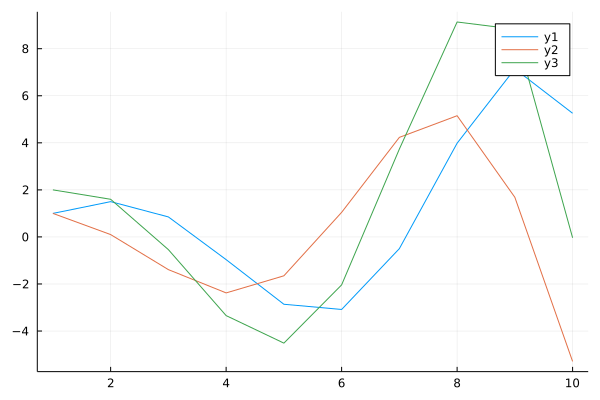

In [5]:
function propagate(A, C, x0, steps)
    n = size(A, 1)
    @assert size(x0,1) == n
    y = zeros(size(C,1), steps) 
    xₜ = x0
    for t in 1:steps
        y[:, t] = C * xₜ
        xₜ = A * xₜ
    end
    return y
end 


A = [ .5  1 
      -1   1.1]

x0 = [1, 1]

C = [1 0 
     0 1 
     1 1]

x = x0

bloch_vec = propagate(A, C, x0, 10)

using Plots
plot(bloch_vec')

Lets check SVD:

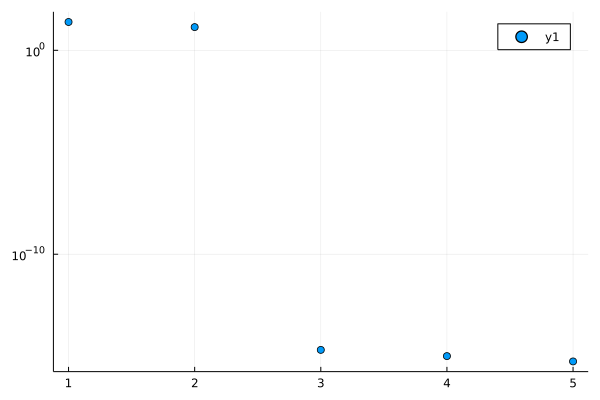

In [6]:
H, m = hankel(bloch_vec) # Hankel matrix and dimention of output (should be 12 in our case)
U, Σ, Vd = svd(H) # Singular value decomposition of H to U,  Σ,  V†
    
scatter(Σ, yaxis=:log)

And estimated rank of the system:

In [7]:
n = argmin(abs.(Σ/maximum(Σ) .- 1e-6)) - 1

2

Now perform linear system identification with the function declared above, Propagate and Plot the identified dynamics of the output of the system

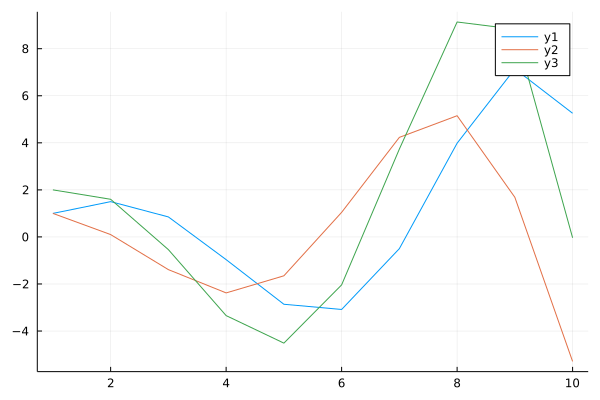

In [8]:
Δt = 1
A_sid, Ac_sid, C_sid, x0_sid  = lsid(bloch_vec, Δt) # δ = 1e-6
bloch_vec_sid = propagate(A_sid, C_sid, x0_sid, 10)
plot(bloch_vec_sid')

Now compare on the same plot

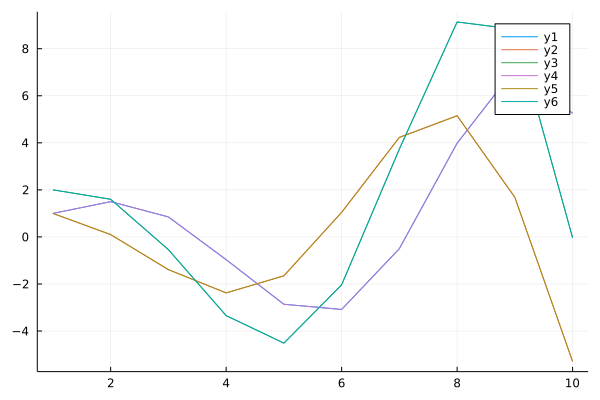

In [9]:
plot(bloch_vec')
plot!(bloch_vec_sid')

In [10]:
A

2×2 Matrix{Float64}:
  0.5  1.0
 -1.0  1.1

In [11]:
A_sid

2×2 Matrix{Float64}:
 0.734897  -0.902329
 1.0132     0.865103

### Now lets test it on random samples

In [12]:
function rand_dm(n)
    # return a random density matrix
    ρ = rand(n, n) + im * rand(n, n)
    ρ = ρ * ρ'
    (ρ / tr(ρ))
end

function rand_herm(n)
    # return a random hermitian matrix
    h = rand(n, n) + im * rand(n, n)
    h = 0.5 * (h + h')
    Hermitian(h)
end

rand_herm (generic function with 1 method)

#### Generate random unitary evolution and plot it

Consider random initial density matrix $\rho$ and random hermitian operator as Hamiltonian $H$,
and then propagate density matrix from $\rho_t$ to $\rho_{t+1}$ on each step:
\begin{align}
    U = \exp(i \Delta t H)\\
    \rho_{t+1} = U \rho_t U^{\dagger}
\end{align}
than on each step consider bloch vector decomposition of density matrix by Pauli matrices:
\begin{align}
    b_t = \left(
        \begin{array}{c}
            { Tr(\rho_t \sigma_1)  }\\
            { Tr(\rho_t \sigma_2   }\\
             {Tr(\rho_t \sigma_3)  }
        \end{array}
    \right)
\end{align}

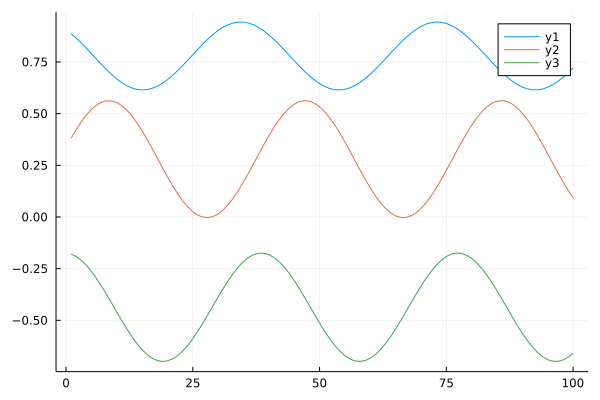

In [14]:
# Pauli matricies
σ = [
    [0 1; 1 0], [0 -im; im 0], [1 0; 0 -1], [1 0; 0 1]
];


ρ = rand_dm(2) # random initial density matrix
Δt = 0.1 # time step of propagation
U = exp(Δt * im * rand_herm(2)) # unitary propagator from random Hamiltonian 

bloch_vec = zeros(3, 100)

for t in 1:size(bloch_vec, 2)
    bloch_vec[:, t] = [real(tr(σ[i] * ρ)) for i=1:3]
    ρ = U * ρ * U'
end

plot(bloch_vec')

Try system identification on this unitary evolution (with random parameters)

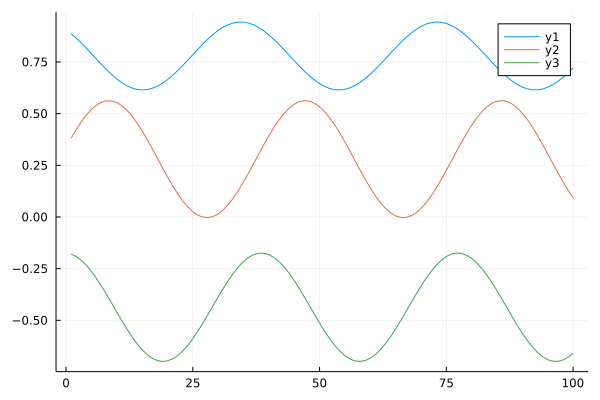

In [15]:
# Δt = 0.1 - we consider it known and are using the same as in data we used for identification 
A_sid, Ac_sid, C_sid, x0_sid  = lsid(bloch_vec, Δt) # δ = 1e-6
bloch_vec_sid = propagate(A_sid, C_sid, x0_sid, size(bloch_vec, 2))
plot(bloch_vec_sid')

In [16]:
C_sid

3×3 Matrix{Float64}:
 -0.800285  -0.0551083   0.244132
 -0.345148   0.401011   -0.154019
  0.422265   0.223334    0.336792

Lets plot original and simulated after identification series on the same plot 

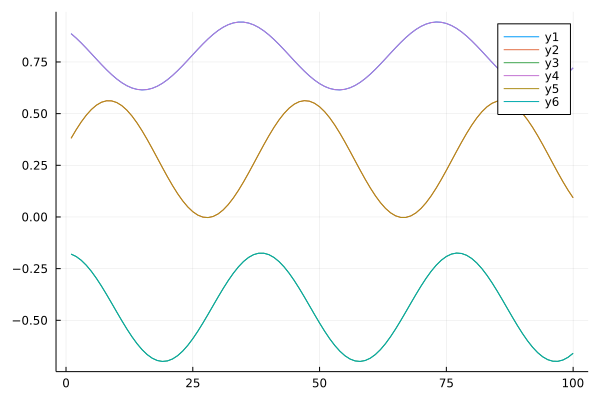

In [17]:
plot(bloch_vec')
plot!(bloch_vec_sid')

As we can see error is increasing over time but remain very low

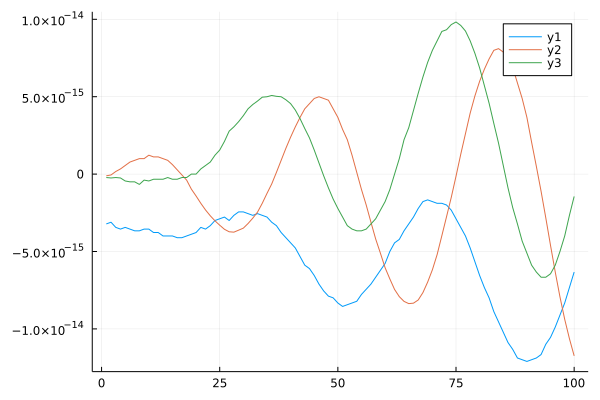

In [20]:
plot(bloch_vec' - bloch_vec_sid')

Check the maximum error

In [25]:
maximum(bloch_vec - bloch_vec_sid)

9.825473767932635e-15

Lets check maximum error on multiple random examples of unitary evolution

In [28]:
Δt = 0.1

number_of_samples = 1000

max_errors = zeros(number_of_samples)

for i in 1:number_of_samples
    ρ = rand_dm(2)
    U = exp(Δt * im * rand_herm(2))
    bloch_vec = zeros(3, 100)
    for t in 1:size(bloch_vec, 2)
        bloch_vec[:, t] = [real(tr(σ[i] * ρ)) for i=1:3]
        ρ = U * ρ * U'
    end
    A_sid, Ac_sid, C_sid, x0_sid  = lsid(bloch_vec, Δt) # δ = 1e-6
    bloch_vec_sid = propagate(A_sid, C_sid, x0_sid, size(bloch_vec, 2))
    max_errors[i] = maximum(bloch_vec - bloch_vec_sid)
end
maximum(max_errors)

Plots below confirm that error remains very low for all samples

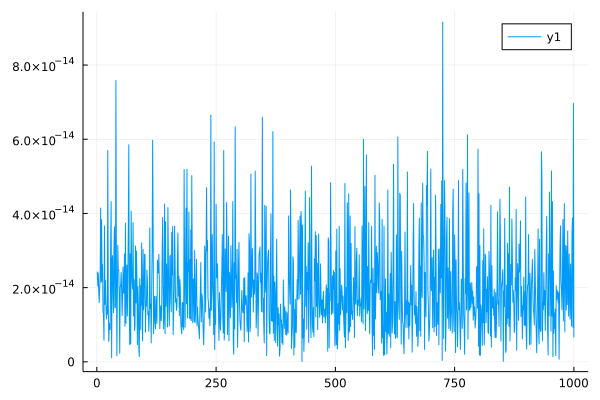

In [29]:
plot(max_errors)

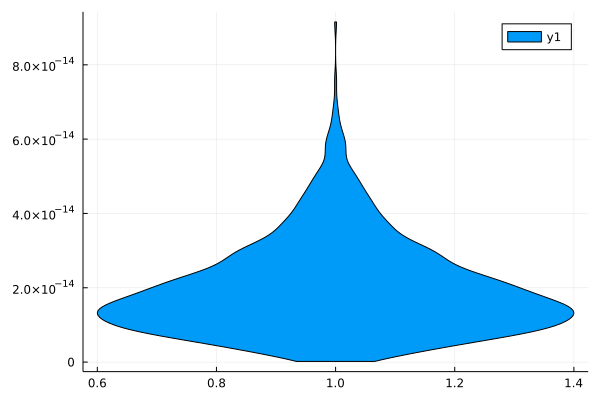

In [31]:
using StatsPlots
violin(max_errors)